In [1]:
# Hellwarth 1999 PRB - Part IV; T-dep of the Feynman variation parameter
# A Friday afternoon of hacking to try and implement the T-dep electron-phonon coupling from the above PRB
# Which was unusually successful! And more or less reproduced Table III

In [2]:
# Just in case anyone is following this from the far future; we are using:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [3]:
# one-dimensional numerical integration in Julia using adaptive Gauss-Kronrod quadrature
using QuadGK

# Equation numbers follow above Hellwarth 1999 PRB
# 62b
A(v,w,β)=3/β*( log(v/w) - 1/2*log(2*π*β) - log(sinh(v*β/2)/sinh(w*β/2)))

# 62d
Y(x,v,β)=1/(1-exp(-v*β))*(1+exp(-v*β)-exp(-v*x)-exp(v*(x-β)))
# 62c integrand
f(x,v,w,β)=(exp(β-x)+exp(x))/(w^2*x*(1-x/β)+Y(x,v,β)*(v^2-w^2)/v)^(1/2)
# 62c
B(v,w,β,α) = α*v/(sqrt(π)*(exp(β)-1)) * quadgk(x->f(x,v,w,β),0,β/2)[1]
#62e
C(v,w,β)=3/4*(v^2-w^2)/v * (coth(v*β/2)-2/(v*β))

F(v,w,β,α)=-(A(v,w,β)+B(v,w,β,α)+C(v,w,β)) #(62a)

# Can now evaluate, e.g.
# F(v,w,β,α)=F(7.2,6.5,1.0,1.0)
# BUT - this is just the objective function! Not the optimised parameters.
# Also there's a scary numeric integration (quadgk) buried within...

F (generic function with 1 method)

In [4]:
# Print out F(alpha,beta) for a specific v,w; as a test
@printf("\t\t")
for α in 1:5
    @printf("α=%d\t\t",α)
end
@printf("\n")

for β in 1:0.25:3.0
    v=w=4
    print("β: $β  \t||")
    for α in 1:5
        @printf("%f\t",F(v,w,β,α))
    end
    println()
end

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||0.948149	-0.860517	-2.669184	-4.477850	-6.286517	
β: 1.25  	||0.837826	-0.797573	-2.432973	-4.068372	-5.703771	
β: 1.5  	||0.731167	-0.781009	-2.293184	-3.805360	-5.317535	
β: 1.75  	||0.634483	-0.786028	-2.206538	-3.627049	-5.047560	
β: 2.0  	||0.548050	-0.802169	-2.152387	-3.502605	-4.852824	
β: 2.25  	||0.470735	-0.824402	-2.119538	-3.414675	-4.709811	
β: 2.5  	||0.401226	-0.850049	-2.101324	-3.352599	-4.603874	
β: 2.75  	||0.338349	-0.877564	-2.093476	-3.309388	-4.525300	
β: 3.0  	||0.281128	-0.905989	-2.093106	-3.280223	-4.467340	


In [5]:
# OK - very primitive!
# But these are 1D traces along the solution for Alpha=Beta=1 in Helwarth PRB TABLE III,
# this was used to correct a transcription error in the above typed-in equations
# It was also good to see what F(v,w) looked like as a function of v and w near an optimal solution

v=7.20
w=6.5
α=1.0
β=1.0

for v=6:0.1:8
    @printf("%f %f\n",v,F(v,w,β,α))
end

@printf("\n")
v=7.20
for w=6:0.1:7
    @printf("%f %f\n",w,F(v,w,β,α))
end

6.000000 0.991013
6.100000 0.980559
6.200000 0.971051
6.300000 0.962484
6.400000 0.954852
6.500000 0.948149
6.600000 0.942368
6.700000 0.937501
6.800000 0.933540
6.900000 0.930475
7.000000 0.928297
7.100000 0.926997
7.200000 0.926565
7.300000 0.926990
7.400000 0.928261
7.500000 0.930368
7.600000 0.933300
7.700000 0.937045
7.800000 0.941592
7.900000 0.946930
8.000000 0.953047

6.000000 0.936794
6.100000 0.933154
6.200000 0.930295
6.300000 0.928232
6.400000 0.926983
6.500000 0.926565
6.600000 0.926993
6.700000 0.928281
6.800000 0.930446
6.900000 0.933502
7.000000 0.937462


In [6]:
# Angle for the ringside seats, when the fall, don't blame me, Bring on the Major Leagues
using Optim
# Julia package stuffed full of magic, does auto-differentation & etc. etc.

In [7]:
Fopt(x) = F(x[1],x[2],1,1)

Fopt([7.2,6.5])
# OK! It looks like I can bury the alpha, beta parameters (which we don't optimise), by wrapping our function in a function definition.

0.9265650282717047

In [8]:
initial=[7.2,6.5]

optimize(Fopt,  initial, LBFGS())

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [7.2,6.5]
 * Minimizer: [7.2001204422454705,6.499877874759114]
 * Minimum: 9.265650e-01
 * Iterations: 5
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 20
 * Gradient Calls: 20

In [9]:
optimize(Fopt, initial, BFGS(), Optim.Options(autodiff=true))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [7.2,6.5]
 * Minimizer: [7.202559224930345,6.502370805840276]
 * Minimum: 9.265650e-01
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 20
 * Gradient Calls: 20

In [10]:
optimize(Fopt, initial, BFGS(), Optim.Options(autodiff=true))

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [7.2,6.5]
 * Minimizer: [7.202559224930345,6.502370805840276]
 * Minimum: 9.265650e-01
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: true
   * f(x) > f(x'): true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 20
 * Gradient Calls: 20

In [11]:
# Right! The above looks like this might actually just work...

@printf("\t\t")
for α in 1:5
    @printf("α=%d\t\t",α)
end
@printf("\n")

for β in 1:0.25:3.0
    print("β: $β  \t||")
    for α in 1:5
        myf(x) = F(x[1],x[2],β,α)
        solution=Optim.minimizer(optimize(myf, initial,ConjugateGradient(), Optim.Options(autodiff=true)))
        
        #print(solution,"\t")
        @printf("%.2f %.2f\t",solution[1],solution[2])
    end
    println()
end

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||7.20 6.50	7.69 6.20	8.26 5.87	8.95 5.51	9.78 5.13	
β: 1.25  	||5.94 5.31	6.38 5.03	6.91 4.73	7.57 4.41	8.39 4.05	
β: 1.5  	||5.11 4.54	5.52 4.29	6.02 4.00	6.66 3.70	7.48 3.37	
β: 1.75  	||4.54 4.01	4.91 3.76	5.40 3.51	6.02 3.22	6.83 2.92	
β: 2.0  	||4.12 3.63	4.48 3.40	4.94 3.16	

LoadError: DomainError:

In [12]:
# After a bit of fiddling, I figured out how to add bounds, to stop that 'DomainError', 
# which occurs where the you are evaluating log(-ve Real), i.e. w<0.0 or v<0.0

initial=[7.2,6.5]

lower=[0.0,0.0]
upper=[10.0,10.0]

@printf("\t\t")
for α in 1:5
    @printf("α=%d\t\t",α)
end
@printf("\n")

for β in 1:0.25:3.0
    print("β: $β  \t||")
    for α in 1:5
        myf(x) = F(x[1],x[2],β,α)
        solution=optimize(DifferentiableFunction(myf), initial, lower, upper, Fminbox(); optimizer = ConjugateGradient, optimizer_o=Optim.Options(autodiff=true))
        minimum=Optim.minimizer(solution)
        
        v=minimum[1]
        w=minimum[2]
        #print(solution,"\t")
        @printf("%.2f %.2f\t",v,w)
        
        
    end
    println()
end

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in DifferentiableFunction(::Function, ::Vararg{Function,N}) at ./deprecated.jl:50
 in macro expansion; at ./In[12]:19 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/jarvist/.julia/v0.5/IJulia/src/execute_request.jl:157
 in eventloop(::ZMQ.Socket) at /Users/jarvist/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[12], in expression starting on line 15


7.20 6.50	7.68 6.19	8.05 5.66	8.94 5.50	9.78 5.12	
β: 1.25  	||5.87 5.25	6.33 4.99	6.92 4.74	7.56 4.40	8.39 4.05	
β: 1.5  	||5.08 4.50	5.52 4.28	6.01 4.00	6.61 3.66	7.48 3.37	
β: 1.75  	||4.58 4.05	4.91 3.76	5.39 3.50	6.02 3.23	6.84 2.92	
β: 2.0  	||4.14 3.65	4.49 3.42	4.94 3.16	5.54 2.89	6.36 2.60	
β: 2.25  	||3.81 3.35	4.14 3.13	4.59 2.89	5.18 2.64	6.00 2.37	
β: 2.5  	||3.59 3.15	3.90 2.94	4.31 2.70	4.90 2.46	5.71 2.20	
β: 2.75  	||3.41 2.99	3

.70 2.77	4.11 2.56	4.67 2.32	5.48 2.07	
β: 3.0  	||3.25 2.85	3.54 2.65	3.93 2.44	4.49 2.22	5.29 1.97	


In [13]:
# So that looks really good! I was super stoked to see how close these values are to TABLE III in Hellwarth
# However, the solutions all start on (7.20,6.50) so that top-left data point is cheating, whereas the 
# others have some disagreement / noise associated with them
# I was wondering whether it might be a function of the optimiser, so thought I'd try them all

initial=[7.1,6.5]
# Main use of these bounds is stopping v or w going negative, at which you get a NaN error as you are evaluating log(-ve Real)
lower=[1.0,1.0]
upper=[10.0,10.0]

for optimizer in [BFGS, LBFGS, ConjugateGradient] # Newton, GradientDescent, NelderMead - steps outside box & log(-ve)->NaN error
    @printf("\n\t\t##### NOW TRIALING: %s #####\n\n",optimizer)

    @printf("\t\t")
    for α in 1:5
        @printf("α=%d\t\t",α)
    end
    @printf("\n")

    for β in 1:0.25:3.0
        print("β: $β  \t||")
        for α in 1:5
            myf(x) = F(x[1],x[2],β,α)
            res=optimize(DifferentiableFunction(myf), initial, lower, upper, Fminbox(); optimizer = optimizer, optimizer_o=Optim.Options(autodiff=true))
            minimum=Optim.minimizer(res)
            #show(Optim.converged(res)) # All came out as 'true'
                
            #print(solution,"\t")
            @printf("%.2f %.2f\t",minimum[1],minimum[2])
        end
        println()
    end
end


		##### NOW TRIALING: Optim.BFGS{L<:Function,H<:Function} #####

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||7.15 6.45	7.68 6.19	8.26 5.87	8.94 5.51	9.78 5.13	
β: 1.25  	||5.94 5.31	6.35 5.01	6.91 4.73	7.57 4.41	8.39 4.05	
β: 1.5  	||5.11 4.53	5.54 4.31	6.01 4.00	6.67 3.71	7.48 3.38	
β: 1.75  	||4.55 4.02	4.94 3.80	5.39 3.51	6.02 3.23	6.83 2.92	
β: 2.0  	||4.15 3.66	4.48 3.41	4.93 3.15	5.55 2.89	6.38 2.62	
β: 2.25  	||3.80 3.34	4.16 3.14	4.59 2.90	5.18 2.64	5.99 2.37	
β: 2.5  	||3.58 3.14	3.89 2.92	4.32 2.70	4.90 2.45	5.71 2.20	
β: 2.75  	||3.38 2.97	3.70 2.78	4.11 2.56	4.67 2.32	5.48 2.07	
β: 3.0  	||3.27 2.87	3.54 2.65	3.93 2.43	4.48 2.21	5.29 1.97	

		##### NOW TRIALING: Optim.LBFGS{T,L<:Function,Tprep<:Union{Function,Void}} #####

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||7.15 6.45	7.70 6.21	8.26 5.86	8.95 5.51	9.79 5.13	
β: 1.25  	||5.94 5.31	6.36 5.01	6.90 4.72	7.57 4.41	8.39 4.05	
β: 1.5  	||5.13 4.56	5.53 4.30	6.03 4.02	6.67 3.72	7.48 3.38	
β: 1.75  	||4.53 4.01	4.93 3.79	5.40 3.51	6.

4.49 3.41	4.94 3.16	5.54 2.88	6.36 2.60	
β: 2.25  	||3.81 3.35	4.15 3.14	4.59 2.90	5.18 2.64	6.00 2.37	
β: 2.5  	||3.58 3.14	3.89 2.93	4.32 2.70	4.90 2.46	5.71 2.20	
β: 2.75  	||3.38 2.96	3.70 2.78	4.10 2.55	4.67 2.32	5.48 2.07	
β: 3.0  	||3.25 2.85	3.54 2.65	3.92 2.43	4.49 2.21	5.29 1.97	

		##### NOW TRIALING: Optim.ConjugateGradient{T,Tprep<:Union{Function,Void},L<:Function} #####

		α=1		α=2		α=3		α=4		α=5		
β: 1.0  	||7.15 6.45	7.67 6.18	8.19 5.80	8.95 5.51	9.78 5.12	
β: 1.25  	||5.91 5.28	6.35 5.01	6.89 4.72	7.56 4.40	8.39 4.05	
β: 1.5  	||5.11 4.54	5.53 4.30	6.04 4.02	6.66 3.70	7.48 3.37	
β: 1.75  	||4.53 4.00	4.93 3.78	5.40 3.51	6.02 3.22	6.83 2.92	
β: 2.0  	||4.17 3.67	4.47 3.39	4.93 3.15	5.54 2.88	6.36 2.60	
β: 2.25  	||3.82 3.35	4.15 3.13	4.59 2.90	5.18 2.64	6.00 2.37	
β: 2.5  	||3.57 3.13	3.91 2.94	4.32 2.70	4.90 2.45	5.71 2.20	
β: 2.75  	||3.38 2.96	3.69 2.77	4.10 2.55	4.67 2.32	5.48 2.07	
β: 3.0  	||3.27 2.87	3.53 2.65	3.92 2.43	4.49 2.21	5.29 1.97	


In [14]:
# So why the (slight) disagreement? I don't really know.
# It may well be that Julia has a much better control of errors, 
# certainly the Optim package (optimisation) defaults seem to be at the Machine-precision end of the world, 
# and a lot of intermediates will be Float64 or larger.

# The objective function seems quite flat in the vicinity of the optimum, so this would also explain some of the variance.

In [15]:
# OK, now Ref 9; Schultz PR Volume 116, Number 3, Nov 1959
const MassElectron = 9.10938188e-31;                          # kg
v=7.15 
w=6.51

m=1.0 #MassElectron
# Eqn (2.4)
μ=m*(v^2-w^2)/v^2
println("Reduced mass: $μ")
rf=(3/2*μ*v)^(1/2)
println("Feynman Polaron Radius: $rf")

# Units?!? Bohr?

Reduced mass: 0.17100885128857163
Feynman Polaron Radius: 1.3542783798281395


In [16]:
using Optim

const hbar = const ħ = 1.05457162825e-34;          # kg m2 / s 
const eV = const q = const ElectronVolt = 1.602176487e-19;                         # kg m2 / s2 
const me=MassElectron = 9.10938188e-31;                          # kg
const Boltzmann = const kB =  1.3806504e-23;                  # kg m2 / K s2 

# "Band Mass" in Deveresse, actually m_b
mb=0.15*me #*1.4 # 0.15 is band reduced mass; 1.4 is polaron renormalised mass

freq=2.25E12
ω = (2*pi)*freq
α=2.395939683378253
@printf("α=%f\n",α)


initial=[7.1,6.5]
#initial=[9.0,9.0]
# Main use of these bounds is stopping v or w going negative, at which you get a NaN error as you are evaluating log(-ve Real)
lower=[0.1,0.1]
upper=[100.0,100.0]


# Empty arrays for storing data 
Ts=[]
Kμs=[]
Hμs=[]
FHIPμs=[]
ks=[]
Ms=[]
As=[]
Bs=[]
Cs=[]
Fs=[]

# I think this β term subsumes the energy of the phonon; i.e. kbT c.f. ħω
for T in 10:10:300
    β=1/(kB*T)
    βred=ħ*ω*β
    @printf("T: %f β: %.2g βred: %.2g\t",T,β,βred)
    myf(x) = F(x[1],x[2],βred,α)
    res=optimize(DifferentiableFunction(myf), initial, lower, upper, Fminbox(); optimizer = BFGS, optimizer_o=Optim.Options(autodiff=true))
    minimum=Optim.minimizer(res)
    #show(Optim.converged(res)) # All came out as 'true'
    
    v=minimum[1]
    w=minimum[2]
        
    @printf(" v= %.2f w= %.2f\t",v,w)
        
    # From 1962 Feynman, definition of v and w in terms of the coupled Mass and spring-constant
    # See Page 1007, just after equation (18)
    # Units of M appear to be 'electron masses'
    # Unsure of units for k, spring coupling constant
    k=(v^2-w^2)
    M=(v^2-w^2)/w^2
    @printf(" M=%f k=%f\t",M,k)
    
    append!(ks,k)
    append!(Ms,M)
    
    # F(v,w,β,α)=-(A(v,w,β)+B(v,w,β,α)+C(v,w,β)) #(62a) - Hellwarth 1999
    @printf("\n Polaron Es: A= %f B= %f C= %f F= %f",A(v,w,βred),B(v,w,βred,α),C(v,w,βred),F(v,w,βred,α))
    append!(As,A(v,w,βred))
    append!(Bs,B(v,w,βred,α))
    append!(Cs,C(v,w,βred))
    append!(Fs,F(v,w,βred,α))
    

    
    #[1.60] in Devereese, page 36; 6th Edition of Frohlich polaron notes
    # I believe here β is in SI (expanded) units
    μ=(w/v)^3 * (3*q)/(4*mb*ħ*ω^2*α*β) * exp(ħ*ω*β) * exp((v^2-w^2)/(w^2*v))
    @printf("\n\tμ(FHIP)= %f m^2/Vs \t= %.2f cm^2/Vs",μ,μ*100^2)
    append!(Ts,T)
    append!(FHIPμs,μ*100^2)
    
    #[1.61] - Kadanoff's Boltzmann eqn derived mob
    μ=(w/v)^3 * (q)/(2*mb*ω*α) * exp(ħ*ω*β) * exp((v^2-w^2)/(w^2*v))
    @printf("\n\tμ(Kadanoff)= %f m^2/Vs \t= %.2f cm^2/Vs",μ,μ*100^2)    

    append!(Kμs,μ*100^2)
    
    #Hellwarth1999 Eqn (2) and (1) - Unclear where from (just references FHIP), contains factors of βred
    R=(v^2-w^2)/(w^2*v) # inline, page 300 just after Eqn (2)
    #b=R*βred/sinh(b*βred*v/2) # this self-references b! what the hell?
    # Oops - it's a typo from Feynman1962!
    b=R*βred/sinh(βred*v/2) # Feynman1962 version; page 1010, Eqn (47b)
    #b=0 # Hellwarth1999/Baggio1997 "Setting b=0 makes less than 0.1% error"
    a=sqrt( (βred/2)^2 + R*βred*coth(βred*v/2))
    k(u,a,b,v) = (u^2+a^2-b*cos(v*u))^(-3/2)*cos(u) # integrand in (2)
    K=quadgk(u->k(u,a,b,v),0,Inf)[1] # numerical quadrature integration of (2)
    
    #Right-hand-side of Eqn 1 in Hellwarth 1999 // Eqn (4) in Baggio1997
    RHS= α/(3*sqrt(π)) * βred^(5/2) / sinh(βred/2) * (v^3/w^3) * K
    μ=RHS^-1 * (q)/(ω*mb)
    @printf("\n\tμ(Hellwarth1999)= %f m^2/Vs \t= %.2f cm^2/Vs",μ,μ*100^2)    
    append!(Hμs,μ*100^2)
    
    #Hellwarth1999 b=0
    R=(v^2-w^2)/(w^2*v) # inline, page 300 just after Eqn (2)
    b=0 # Hellwarth1999/Baggio1997 "Setting b=0 makes less than 0.1% error"
    a=sqrt( (βred/2)^2 + R*βred*coth(βred*v/2))
    k(u,a,b,v) = (u^2+a^2-b*cos(v*u))^(-3/2)*cos(u) # integrand in (2)
    K=quadgk(u->k(u,a,b,v),0,Inf)[1] # numerical quadrature integration of (2)

    #Right-hand-side of Eqn 1 in Hellwarth 1999 // Eqn (4) in Baggio1997
    RHS= α/(3*sqrt(π)) * βred^(5/2) / sinh(βred/2) * (v^3/w^3) * K
    μ=RHS^-1 * (q)/(ω*mb)
    @printf("\n\tμ(Hellwarth1999,b=0)= %f m^2/Vs \t= %.2f cm^2/Vs",μ,μ*100^2)    
    #append!(Hμs,μ*100^2)
    
    
    @printf("\n\n")
    
    # Recycle previous results as next guess
    initial=[v,w] # Caution! Might cause weird sticking in local minima
end

α=2.395940
T: 10

.000000 β: 7.2e+21 βred: 11	 v= 3.07 w= 2.34	 M=0.717178 k=3.925527	
 Polaron Es: A= -1.600060 B= 2.665654 C= 0.902304 F= -1.967899
	μ(FHIP)= 66.070065 m^2/Vs 	= 660700.65 cm^2/Vs
	μ(Kadanoff)= 475.628885 m^2/Vs 	= 4756288.85 cm^2/Vs
	μ(Hellwarth1999)= 65.805034 m^2/Vs 	= 658050.34 cm^2/Vs
	μ(Hellwarth1999,b=0)= 65.805034 m^2/Vs 	= 658050.34 cm^2/Vs

T: 20.000000 β: 3.6e+21 βred: 5.4	 v= 3.05 w= 2.19	 M=0.936635 k=4.507233	
 Polaron Es: A= -2.084111 B= 2.802278 C= 0.972966 F= -1.691132
	μ(FHIP)= 0.536442 m^2/Vs 	= 5364.42 cm^2/Vs
	μ(Kadanoff)= 1.930883 m^2/Vs 	= 19308.83 cm^2/Vs
	μ(Hellwarth1999)= 0.549768 m^2/Vs 	= 5497.68 cm^2/Vs
	μ(Hellwarth1999,b=0)= 0.549774 m^2/Vs 	= 5497.74 cm^2/Vs

T: 30.000000 β: 2.4e+21 βred: 3.6	 v= 3.40 w= 2.38	 M=1.038341 k=5.897853	
 Polaron Es: A= -2.532044 B= 2.991060 C= 1.087716 F= -1.546732
	μ(FHIP)= 0.123011 m^2/Vs 	= 1230.11 cm^2/Vs
	μ(Kadanoff)= 0.295180 m^2/Vs 	= 2951.80 cm^2/Vs
	μ(Hellwarth1999)= 0.125538 m^2/Vs 	= 1255.38 cm^2/Vs
	μ(Hellwarth199

In [17]:
using Plots
default(size=(600,400))


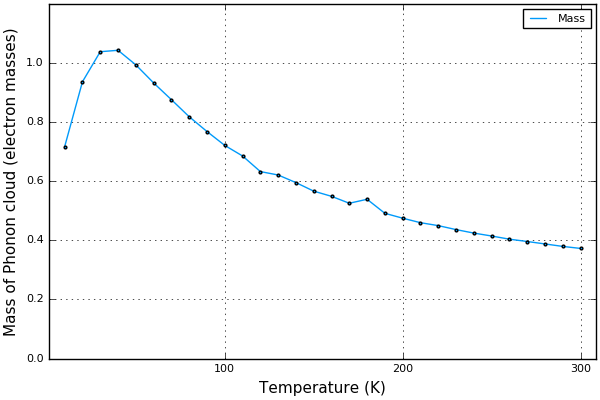

In [18]:
plot(Ts,Ms,label="Mass",marker=2,xlab="Temperature (K)",ylab="Mass of Phonon cloud (electron masses)",ylim=(0,1.2))
#plot!([0],[0])
#plot!(Ts,ks,label="Spring Consts",marker=2)


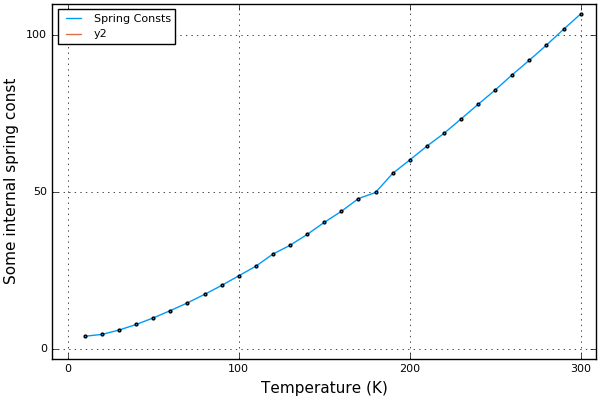

In [19]:
plot(Ts,ks,label="Spring Consts",marker=2, xlab="Temperature (K)",ylab="Some internal spring const",)
plot!([0],[0])



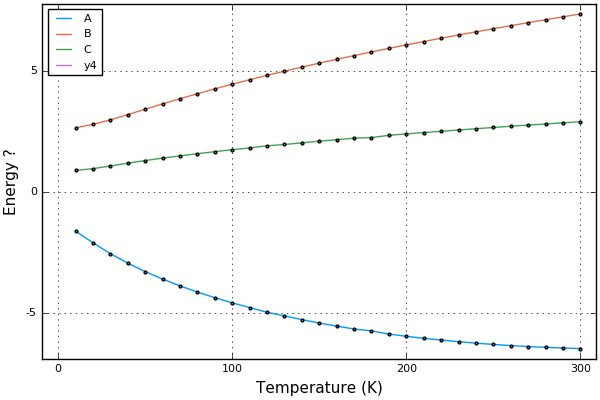

In [20]:
plot(Ts,As,label="A",marker=2, xlab="Temperature (K)",ylab="Energy ?")
plot!(Ts,Bs,label="B",marker=2)
plot!(Ts,Cs,label="C",marker=2)
#plot!(Ts,Fs,label="F",marker=2)


plot!([0],[0])



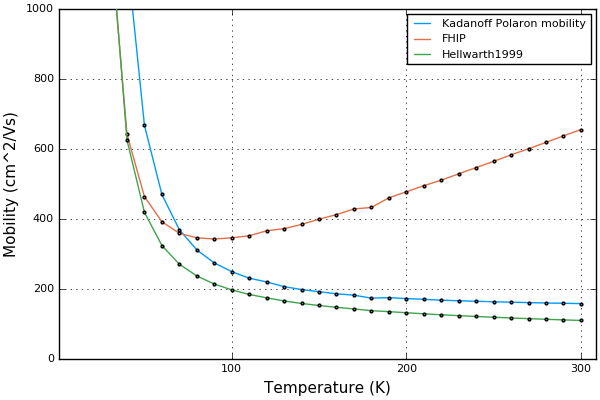

In [21]:
using Plots

default(size=(600,400))
plot(Ts,Kμs,label="Kadanoff Polaron mobility",marker=2,xlab="Temperature (K)",ylab="Mobility (cm^2/Vs)",ylims=(0,1000))
plot!(Ts,FHIPμs,label="FHIP",marker=2)
plot!(Ts,Hμs,label="Hellwarth1999",marker=2)
#plot!([0],[0])


In [22]:
# Milot/Herz 2015 Time-Resolved-Microwave-Conductivity mobilities
# Data from table in SI of: DOI: 10.1002/adfm.201502340
# Absolute values possibly dodge due to unknown yield of charge carriers; but hopefully trend A.OK!
Milot= [
8 184
40 321
80 143
120 62
140 40
160 52
180 44
205 41
230 39
265 26
295 35
310 24
320 24
330 19
340 16
355 15 
]

# IV estimated mobilities (?!) from large single crystals, assumed ambient T
# Nature Communications 6, Article number: 7586 (2015)
# doi:10.1038/ncomms8586
Saidaminov = 
[ 300 67.2 ]


#Semonin2016,
#  doi = {10.1021/acs.jpclett.6b01308},
Semonin = 
[ 300 115 ] # +- 15 cm^2/Vs, holes+electrons

1×2 Array{Int64,2}:
 300  115


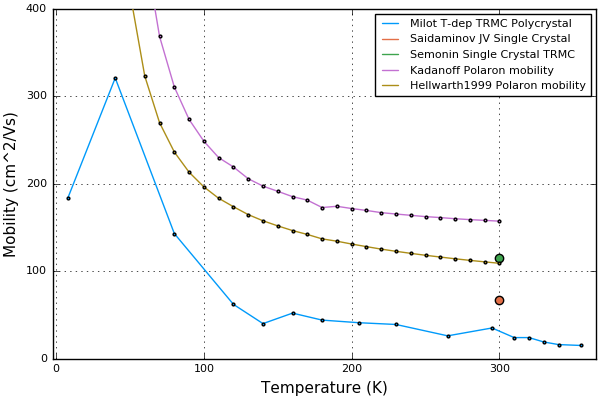

In [23]:
#default(size=(1200,800))

plot(Milot[:,1],Milot[:,2],label="Milot T-dep TRMC Polycrystal",
xlab="Temperature (K)",ylab="Mobility (cm^2/Vs)",marker=2, ylims=(0,400) )
plot!(Saidaminov[:,1],Saidaminov[:,2],label="Saidaminov JV Single Crystal", marker=6)
plot!(Semonin[:,1],Semonin[:,2],label="Semonin Single Crystal TRMC", marker=6)
plot!(Ts,Kμs,label="Kadanoff Polaron mobility",marker=2)
plot!(Ts,Hμs,label="Hellwarth1999 Polaron mobility",marker=2)
#plot!([0],[0])

In [24]:
plot!(yscale=(:log))

In [25]:
default(size=(1200,800))

In [26]:
# OK, now Ref 9 in  Hellwarth 1999 -
# Schultz Physical Review Volume 116, Number 3, Nov 1959
# Slow Electrons in Polar Crystals: Self-Energy,  Mass,  and Mobility

const MassElectron = 9.10938188e-31;                          # kg

# 300 K fit from above
v=19.83 
w= 16.93

# Guess at What Hellwarth 1999 used: 
#  "Using these values we estimate a room-temperature polaron radius of approx 0.6 nm for BiSiO"
# So they're using an omega=500 cm^-1 = 62 meV, so βred=2.5
# Not sure what alpha they are using; (43) gives it in terms of phonon energies + reduced masses
# Best guess for now - alpha=3, βred=2.5, so from Table III
v=4.10 
w=2.55

m=1.0 #MassElectron
# Eqn (2.4), Shultz1959
μ=m*(v^2-w^2)/v^2
println("Reduced mass: $μ")
rf=(3/2*μ*v)^(1/2)
println("Feynman Polaron Radius: $rf , electron-mass unit")
println("Assuming Bohr, that's ",rf*5.2918e-11," m")
rf=(3/2*μ*v*MassElectron)^(1/2)
println("Feynman Polaron Radius: $rf, SI")


# Units?!? Bohr?


Reduced mass: 0.6131766805472932
Feynman Polaron Radius: 1.941915699860798 , electron-mass unit
Assuming Bohr, that's 1.027622950052337e-10 m
Feynman Polaron Radius: 1.8534241915856385e-15, SI


In [27]:
# ((freq THz)) ((IR Activity / e^2 amu^-1))
# These data from MAPbI3-Cubic_PeakTable.csv
# https://github.com/WMD-group/Phonons/tree/master/2015_MAPbI3/SimulatedSpectra
# Data published in Brivio2015 (PRB)
# https://doi.org/10.1103/PhysRevB.92.144308
MAPI= [
96.20813558773261 0.4996300522819191
93.13630357703363 1.7139631746083817
92.87834578121567 0.60108592692181
92.4847918585963 0.0058228799414729
92.26701437594754 0.100590086574602
89.43972834606603 0.006278895133832249
46.89209141511332 0.2460894564364346
46.420949316788 0.14174282581124137
44.0380222871706 0.1987196948553428
42.89702947649343 0.011159939465770681
42.67180170168193 0.02557751102757614
41.46971205834201 0.012555230726601503
37.08982543385215 0.00107488277468418
36.53555265689563 0.02126940080871224
30.20608114002676 0.009019481779712388
27.374810898415028 0.03994453721421388
26.363055017011728 0.05011922682554448
9.522966890022039 0.00075631870522737
4.016471586720514 0.08168931020200264
3.887605410774121 0.006311654262282101
3.5313112232401513 0.05353548710183397
2.755392921480459 0.021303020776321225
2.4380741812443247 0.23162784335484837
2.2490917637719408 0.2622203718355982
2.079632190634424 0.23382298607799906
2.0336707697261187 0.0623239656843172
1.5673011873879714 0.0367465760261409
1.0188379384951798 0.0126328938653956
1.0022960504442775 0.006817361620021601
0.9970130778462072 0.0103757951973341
0.9201781906386209 0.01095811116040592
0.800604081794174 0.0016830270365341532
0.5738689505255512 0.00646428491253749
#0.022939578929507105 8.355742795827834e-05   # Acoustic modes!
#0.04882611767873102 8.309858592685e-06
#0.07575149723846182 2.778248540373041e-05
]

# Change to SI, but not actually needed as units cancel everywhere

#MAPI_SI = [ MAPI_orig[:,1].*10^12*2*π MAPI_orig[:,2].*1 ]

# OK, black magic here - perhaps our units of oscillator strength are not what we need? maybe already effectively 'squared'?
#MAPI = [ MAPI[:,1] MAPI[:,2].^0.5]

MAPI_low=MAPI[19:33,:] # Just inorganic components, everything below 10THz; modes 3-18

15×2 Array{Float64,2}:
 4.01647   0.0816893 
 3.88761   0.00631165
 3.53131   0.0535355 
 2.75539   0.021303  
 2.43807   0.231628  
 2.24909   0.26222   
 2.07963   0.233823  
 2.03367   0.062324  
 1.5673    0.0367466 
 1.01884   0.0126329 
 1.0023    0.00681736
 0.997013  0.0103758 
 0.920178  0.0109581 
 0.800604  0.00168303
 0.573869  0.00646428

In [28]:
# Hellwarth Table II - BiSiO frequencies
HellwarthII = [
    106.23 8.86
    160.51 9.50
    180.33 20.85
    206.69 10.05
    252.76 27.00
    369.64 61.78
    501.71 52.87
    553.60 86.18
    585.36 75.41
    607.29 98.15
    834.53 89.36
]

11×2 Array{Float64,2}:
 106.23   8.86
 160.51   9.5 
 180.33  20.85
 206.69  10.05
 252.76  27.0 
 369.64  61.78
 501.71  52.87
 553.6   86.18
 585.36  75.41
 607.29  98.15
 834.53  89.36

In [29]:
# Most simple scheme
# Hellwarth (58), assuming further typo on LHS, actually should be W_e
function HellwarthBscheme(LO)
    H58 = sum( (LO[:,2].^2)./ LO[:,1].^2 )
    println("Hellwarth (58) summation: ",H58)

    H59 = sum( LO[:,2].^2 ) # sum of total ir activity squarred
    println("Hellwarth (59) summation (total ir activity ^2): ", H59)
    println("Hellwarth (59) W_e (total ir activity ): ", sqrt(H59))


    omega = sqrt(H59 / H58)
    println("Hellwarth (61) Omega (freq): ",omega)
end

HellwarthBscheme(HellwarthII)
println(" should agree with values given in Hellwarth(60) W_e=196.9 cm^-1 and Hellwarth(61) Ω_e=500 cm^-1")
println("\t MAPI: (all values)")
HellwarthBscheme(MAPI)
println("\t MAPI: (low-frequency, non molecular IR)")
HellwarthBscheme(MAPI_low)

Hellwarth (58) summation: 0.15505835776181887
Hellwarth (59) summation (total ir activity ^2): 38777.7725
Hellwarth (59) W_e (total ir activity ): 196.92072643579192
Hellwarth (61) Omega (freq): 500.08501275972833
 should agree with values given in Hellwarth(60) W_e=196.9 cm^-1 and Hellwarth(61) Ω_e=500 cm^-1
	 MAPI: (all values)
Hellwarth (58) summation: 0.038509373484332976
Hellwarth (59) summation (total ir activity ^2): 3.8773458912320917
Hellwarth (59) W_e (total ir activity ): 1.9690977353173944
Hellwarth (61) Omega (freq): 10.034229876494392
	 MAPI: (low-frequency, non molecular IR)
Hellwarth (58) summation: 0.03803673767058733
Hellwarth (59) summation (total ir activity ^2): 0.19283002835623678
Hellwarth (59) W_e (total ir activity ): 0.4391241605243747
Hellwarth (61) Omega (freq): 2.251571287857919


In [30]:
# Check this though, take the low-freq components and:
MAPI_low=[
9.522966890022039 0.00075631870522737
4.016471586720514 0.08168931020200264
3.887605410774121 0.006311654262282101
3.5313112232401513 0.05353548710183397
2.755392921480459 0.021303020776321225
2.4380741812443247 0.23162784335484837
2.2490917637719408 0.2622203718355982
2.079632190634424 0.23382298607799906
2.0336707697261187 0.0623239656843172
1.5673011873879714 0.0367465760261409
1.0188379384951798 0.0126328938653956
1.0022960504442775 0.006817361620021601
0.9970130778462072 0.0103757951973341
0.9201781906386209 0.01095811116040592
0.800604081794174 0.0016830270365341532
0.5738689505255512 0.00646428491253749
#0.022939578929507105 8.355742795827834e-05
#0.04882611767873102 8.309858592685e-06
#0.07575149723846182 2.778248540373041e-05
]
H58 = sum( (MAPI_low[:,2].^2)./ MAPI_low[:,1].^2 )
println("Hellwarth (58) summation: ",H58)

H59 = sum( MAPI_low[:,2].^2 ) # sum of total ir activity squarred
println("Hellwarth (59) summation (total ir activity ^2): ", H59)

omega = sqrt(H59 / H58)
println("Hellwarth (61) Omega (Thz): ",omega)

# That feels like it should be the right answer... for whatever reason the Hellwarth 
# prescription isn't cancelling out the high-frequency components as you would expect 
# it to from an integration across the Lorentz oscillators

Hellwarth (58) summation: 0.03803674397820172
Hellwarth (59) summation (total ir activity ^2): 0.19283060037422062
Hellwarth (61) Omega (Thz): 2.2515744407380125


In [31]:
# More complex scheme, involving thermodynamic Beta
# Hellwarth(50), RHS
const hbar = const ħ = 1.05457162825e-34;          # kg m2 / s 
const eV = const q = const ElectronVolt = 1.602176487e-19;                         # kg m2 / s2 
const me=MassElectron = 9.10938188e-31;                          # kg
const Boltzmann = const kB =  1.3806504e-23;                  # kg m2 / K s2 

function HellwarthAscheme(LO,T=295)
    
    β=LO[:,1].*2*pi*1E12*ħ/(kB*T) #assuming units of THz
    H50 = sum( ((LO[:,2].^2).*coth(β))./LO[:,1] )
    println("Hellwarth (50) summation: ",H50)

    H51= sum( LO[:,2].^2 ) # sum of total ir activity squarred
    println("Hellwarth (51) summation (total ir activity ^2): ", H51)
    println("Hellwarth (51) W_e (total ir activity ): ", sqrt(H51))

    # OK; so this is deriving Omega / coth(Beta/2)
    omegacoth=H51/H50
    println("omegacoth: ",omegacoth)

    # NOT FINISHED - need to somehow decouple Omega from both sides of the eqn. 
    for freq in 0.25:0.25:20
        pseudo_omega=omegacoth*coth(freq * 2*pi*1E12*ħ/(2*kB*T))
        println("freq: $freq pseudo-omega: $pseudo_omega")
    end
end

HellwarthAscheme(HellwarthII)
HellwarthAscheme( [HellwarthII[:,1].*0.02998 HellwarthII[:,2]] ) # convert data to Thz
println(" should agree with values given in Hellwarth\n TableII: H50sum= 91.34 cm^-1, \n W_e=196.9 cm^-1 and Hellwarth(53) Ω_e=504 cm^-1")

println("\t MAPI: (all values)")
HellwarthAscheme(MAPI)
println("\t MAPI: (low-frequency, non molecular IR)")
HellwarthAscheme(MAPI_low)

Hellwarth (50) summation: 71.54392838926714
Hellwarth (51) summation (total ir activity ^2): 38777.7725
Hellwarth (51) W_e (total ir activity ): 196.92072643579192
omegacoth: 542.0134646368867
freq: 0.25 pseudo-omega: 26656.90416473002
freq: 0.5 pseudo-omega: 13333.9624483481
freq: 0.75 pseudo-omega: 8895.429577943587
freq: 1.0 pseudo-omega: 6677.997401735134
freq: 1.25 pseudo-omega: 5349.003805836801
freq: 1.5 pseudo-omega: 4464.227684345397
freq: 1.75 pseudo-omega: 3833.2882211840815
freq: 2.0 pseudo-omega: 3360.9947109117875
freq: 2.25 pseudo-omega: 2994.4631659655356
freq: 2.5 pseudo-omega: 2701.962959828391
freq: 2.75 pseudo-omega: 2463.3016650751006
freq: 3.0 pseudo-omega: 2265.0174726122787
freq: 3.25 pseudo-omega: 2097.790494542239
freq: 3.5 pseudo-omega: 1954.9635088340199
freq: 3.75 pseudo-omega: 1831.6544062868716
freq: 4.0 pseudo-omega: 1724.2014700285679
freq: 4.25 pseudo-omega: 1629.8044388530136
freq: 4.5 pseudo-omega: 1546.2852162327458
freq: 4.75 pseudo-omega: 1471.924

In [32]:
# Comparison via Hellwarth (37)
# MAPI  4.5, 24.1, 2.25THz - 75 cm^-1 ; α=
ε_Inf=4.5
ε_S=24.1

(1/ε_Inf - 1/ε_S) #/(4*pi)

# By Hellwarth (37) this should be equivalent to the summation Hellwarth(58) above

0.18072844628861226

In [33]:
# Hellwarth 44 defin. for alpha
Ry=13.605693*q
effectivemass=0.12
α=(1/ε_Inf - 1/ε_S) * sqrt(effectivemass * Ry / (ħ*2.25E12*2*pi))

2.393940840504799

In [34]:
# Integrate through Lorentz oscillators to get dielectric fn
# Should give 'extra' contribution from these modes, extrapolated to zero omega
function integrate_dielectric(LO,V0)
    summate=sum( (LO[:,2])./(LO[:,1].^2) )
    summate*4*π/V0
end

Å=1E-10 # angstrom in metres
r=6.29Å # Sensible cubic cell size
V0=(r)^3
println("volume: $V0")
const amu=1.66054e-27
const ε0=8.854187817E-12

MAPI_SI = [ MAPI[:,1].*10^12*2*π MAPI[:,2]./(q^2/amu) ]

println(" MAPI: ",integrate_dielectric(MAPI,1.0))
println(" MAPI_low: ",integrate_dielectric(MAPI_low,1.0))
println(" MAPI_SI: ",integrate_dielectric(MAPI_SI,V0))
println(" MAPI_SI: fudged epislon0 ",integrate_dielectric(MAPI_SI,V0)*ε0/(4*π))
println(" MAPI_SI_low: fudged epislon0 ",integrate_dielectric(MAPI_SI[19:33,:],V0)*ε0/(4*π))


println()
println("From ε_S-ε_Inf, expect this to be: ",ε_S-ε_Inf)

volume: 2.48858189e-28
 MAPI: 3.1776873962678347
 MAPI_low: 3.1677081975618884
 MAPI_SI: 2.0923201242420605e13
 MAPI_SI: fudged epislon0 14.742359525955068
 MAPI_SI_low: fudged epislon0 14.695576457826046

From ε_S-ε_Inf, expect this to be: 19.6


In [35]:
sum(MAPI[:,2]./MAPI[:,1].^2 )

0.25287232835842016

In [36]:
sum(MAPI_low[:,2]./MAPI_low[:,1].^2 )

0.25207820895734634

In [41]:
println("Debye temperatures...")
freq=2.25E12 # Thz
ω = (2*pi)*freq
println("MAPI: 2.25 THz: ",hbar*ω/kB)

# GaP:
# 10.1002/pssb.2221200123
# TO mode at Gamma: 402.5 cm^-1
freq=12.06665E12 # Thz
ω = (2*pi)*freq
hbar*ω/kB
println("GaP: 12.066 THz: ",hbar*ω/kB)


Debye temperatures...
MAPI: 2.25 THz: 107.98284026119079
GaP: 12.066 THz: 579.1071730834212


In [56]:
meSmallAlpha(α)=α/6 + 0.025*α^2
# (46) In Feynman1955
meLargeAlpha(α)=16*α^4 / (81*π^4)
meLargeAlpha(α)=202*(α/10)^4

println("MAPI: electron, α=2.40 meSmallAlpha(α)=",meSmallAlpha(2.40)," meLargeAlpha(α)=",meLargeAlpha(2.40))
println("MAPI: hole,     α=2.68 meSmallAlpha(α)=",meSmallAlpha(2.68)," meLargeAlpha(α)=",meLargeAlpha(2.68))

MAPI: electron, α=2.40 meSmallAlpha(α)=0.5439999999999999 meLargeAlpha(α)=0.6701875199999999
MAPI: hole,     α=2.68 meSmallAlpha(α)=0.6262266666666667 meLargeAlpha(α)=1.0420547691520003
